<a href="https://colab.research.google.com/github/catalyst2064/spiking-neural-network/blob/main/note%2304_BindsNET_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ソースコード

## BindsNETのインストール

3〜4分かかります。

In [1]:
!pip install git+https://github.com/BindsNET/bindsnet.git

  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-zgjz7cdy
  Running command git clone --filter=blob:none --quiet https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-zgjz7cdy
  Resolved https://github.com/BindsNET/bindsnet.git to commit f4e5a9da90766114b6cd415e8c319d70d083eee3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.5 MB/s eta 

## インポート／ユーティリティ／環境設定

In [2]:
#-------------------------------------------------
# インポート
#-------------------------------------------------

from abc import ABCMeta, abstractmethod
from types import SimpleNamespace
from time import time as t
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from bindsnet.models import DiehlAndCook2015      # Diehl&Cook(2015)モデル
from bindsnet.encoding import PoissonEncoder      # ポアソンエンコーダ
from bindsnet.evaluation import all_activity, assign_labels
from bindsnet.network.monitors import Monitor

from torchvision.datasets import MNIST            # 手書き数字（MNIST）
from sklearn.datasets import load_digits          # 手書き数字（digits）

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc

#-------------------------------------------------
# ユーティリティ
#-------------------------------------------------

def set_seed(seed):                               # 乱数シードを設定
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

#-------------------------------------------------
# 環境設定
#-------------------------------------------------

%config InlineBackend.figure_format = 'retina'            # 高精細で図を描画する

np.set_printoptions(formatter={'float':'{: .8f}'.format}) # 数値の表示を整える


/usr/local/lib/python3.10/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


## データセット

In [3]:
class DatasetBase(metaclass=ABCMeta):
    def __init__(self):
        self.ss_train = None                      # トレーニングセット
        self.ss_valid = None                      # バリデーションセット（今回は見送り）
        self.ss_test  = None                      # テストセット

    @staticmethod
    def shuffle(data, label):                     # 要素の対応関係を保ったままシャッフル
        zipped = list(zip(data, label))
        np.random.shuffle(zipped)
        return zip(*zipped)

    @staticmethod
    def restruct(ds, shape):                      # データセットを共通化するための再構築
        def convert(data):                        # とりあえず、画像認識専用バージョン
            data = torch.tensor(data/16*255, dtype=torch.uint8) # 17階調から256階調に変換
            data = data.view(-1, shape[1], shape[2])
            return data
        ss_train = SimpleNamespace()
        ss_test  = SimpleNamespace()
        ss_train.data, ss_test.data, ss_train.targets, ss_test.targets \
                = train_test_split(ds.data, ds.target, test_size=0.25, shuffle=False)
        ss_train.data = convert(ss_train.data)
        ss_test.data  = convert(ss_test.data)
        return (ss_train, ss_test)

    @staticmethod
    def preproc(HP, org, size, shape):            # シャッフル、スライス、エンコード
        ss = SimpleNamespace()
        (ss.data, ss.label) = DatasetBase.shuffle(org.data, org.targets)
        ss.data   = torch.tensor(np.array(ss.data[:size]))
        ss.label  = torch.tensor(np.array(ss.label[:size]))
        encoder   = PoissonEncoder(time=HP.time, dt=HP.dt)
        ss.spiket = torch.tensor(
            np.array([ encoder(data) for data in ss.data ])  # ポアソンエンコーディング
        ).view(size, HP.nt, shape[0], shape[1], shape[2])    # 配列の形状をBindsNETに合わせる
        return ss

    @abstractmethod
    def load(self, HP, DA):                       # データセットの読み込みと前処理
        pass

class DatasetMNIST(DatasetBase):                  # MNISTデータセット
    def load(self, HP, DA):
        ss_train = MNIST(root='./data', train=True,  download=True)
        ss_test  = MNIST(root='./data', train=False, download=True)
        self.ss_train = self.preproc(HP, ss_train, DA.n_train, DA.shape)
        self.ss_test  = self.preproc(HP, ss_test,  DA.n_test,  DA.shape)

class DatasetDigits(DatasetBase):                 # digitsデータセット
    def load(self, HP, DA):
        digits = load_digits()                    # データ数 = 1,797件
        (ss_train, ss_test) = self.restruct(digits, DA.shape)
        self.ss_train = self.preproc(HP, ss_train, DA.n_train, DA.shape)
        self.ss_test  = self.preproc(HP, ss_test,  DA.n_test,  DA.shape)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## ビジュアライザ

In [4]:
class Visualizer:
    @staticmethod
    def show_dataimage(data, label, fs=(6,4)):    # データを256階調グレー画像として表示
        plt.figure(figsize=fs)
        plt.subplots_adjust(wspace=0, hspace=0)
        for (i, (data, label)) in enumerate(zip(data, label)):
            plt.subplot(2, 5, i + 1)
            plt.axis('off')
            plt.title(int(label))
            plt.imshow(data, vmin=0, vmax=255, cmap='Greys')
        plt.show()

    @staticmethod
    def show_rasterplot(spiket, fs=(8,3)):        # ラスタープロットを表示
        plt.figure(figsize=fs)
        x_axis = range(spiket.shape[1])
        raster = np.where(spiket == 0, np.nan, spiket) # 0をNaNに置換
        for (i, raster) in enumerate(raster):
            plt.scatter(x_axis, raster*i, s=1.0, c='mediumblue')
        plt.xlabel('Time [ms]')
        plt.ylabel('Pixel #')
        plt.show()

    @staticmethod
    def show_spiketrain(spiket, fs=(8,4)):        # スパイクトレインを表示
        plt.figure(figsize=fs)
        plt.grid(True, linestyle='--', linewidth=0.5)
        event = [np.where(_)[0] for _ in spiket]  # スパイクイベントを収集
        plt.eventplot(event, linelengths=0.5, colors='mediumblue')
        plt.xlabel('Time [ms]')
        plt.ylabel('Pixel #')
        plt.show()

    @staticmethod
    def show_labelcount(map, fs=(5,4)):           # ラベルの出現頻度を表示
        plt.figure(figsize=fs)
        label, counts = np.unique(map, return_counts=True)
        plt.bar(label, counts, align='center')
        for (i, count) in enumerate(counts):
            plt.text(i, count, str(count), ha='center', va='bottom')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.xticks(label)
        plt.show()


## メトリクス

In [5]:
class Metrics:
    def __init__(self, epochs=None, n_train=None):
        self.epochs  = epochs
        self.n_train = n_train
        self.reset()

    def reset(self, epoch=None):                  # 正解率の算出用データを初期化
        self.epoch = epoch
        self.count = 0                            # 正解数のカウント
        self.total = 0                            # データの総数

    def update(self, labels, pred):               # 正解率の算出用データを更新
        labels = torch.tensor(labels)
        self.count += torch.sum(labels == pred).item()
        self.total += len(labels)

    @staticmethod
    def judge(flag):                              # 論理値を判定文字列に変換
        return '✓ PASS' if flag else '✗ FAIL'

    def selfdiag(self, assumed_accu):             # コードの自己診断（想定正解率を利用）
        actual_accu = round(self.count / self.total * 100, 2)
        matched = actual_accu == assumed_accu
        print(f'actual accu = {actual_accu:.2f}%, '
              f'assumed accu = {assumed_accu:.2f}%, '
              f'result = {self.judge(matched)}\n')
        assert actual_accu == assumed_accu, \
               'The code may be broken.'          # 実行正解率と想定正解率が一致しなかったので中断

    def show_progress(self, step, time):          # 進行状況を表示
        actual_accu = round(self.count / self.total * 100, 2)
        print(f'epoch = {self.epoch + 1} / {self.epochs}, '
              f'update = {step + 1:>3d} / {self.n_train}, '
              f'accuracy = {actual_accu:.2f}%, '
              f'time = {time:.1f}秒（{round(time/60)}分）')

    def show_judge(self, step, label, pred):      # 判定結果を表示
        matched = label == pred
        self.count += int(matched)
        self.total += 1
        print(f'data = {step:>2d}, pred = {pred}, '
              f'label = {label}, '
              f'judge = {self.judge(matched)}')

    def show_result(self):                        # 最終的な結果を表示
        print(f'正解率 = {self.count / self.total * 100:.2f}%')


## ネットワーク

In [6]:
class Network(DiehlAndCook2015):
    def __init__(self, HP, DA):
        super().__init__(
            n_inpt     = DA.inputs,               # 入力層における入力数
            n_neurons  = HP.neurons,              # ニューロンの数（興奮性、抑制性）
            exc        = HP.exc,                  # シナプスの強度（興奮性層→抑制性層）
            inh        = HP.inh,                  # シナプスの強度（抑制性層→興奮性層）
            dt         = HP.dt,                   # 時間分解能
            norm       = DA.inputs / 10,          # 接続強度の正規化（入力層→興奮性層）（学習に大きく影響する）
            inpt_shape = DA.shape)                # 入力データの形状
        self.spikes = self.__set_spiketracer(HP.nt)
        self.map    = -torch.ones(HP.neurons)
        self.rates  = torch.zeros((HP.neurons, DA.classes))
        self.HP = HP
        self.DA = DA

    def __set_spiketracer(self, nt):              # スパイクトレーサーを設定
        spikes = {}
        for layer in set(self.layers):
            spikes[layer] = Monitor(
                self.layers[layer],
                state_vars = ['s'],
                time       = nt)
            self.add_monitor(spikes[layer], name='%s_spikes' % layer)
        return spikes

    def trainmode(self, mode, size):              #
        self.train(mode=mode)
        self.spike_record = torch.zeros((size, self.HP.nt, self.HP.neurons))

    def forward(self, spiket, index):             # 入力層にスパイクトレインを投入する
        s = self.DA.shape
        X = { 'X': spiket.view(self.HP.nt, 1, s[0], s[1], s[2]) }
        self.run(inputs=X, time=self.HP.time)
        self.spike_record[index] = self.spikes['Ae'].get('s').squeeze()

    def predict(self):                            # 予測
        return all_activity(
            spikes      = self.spike_record,
            assignments = self.map,
            n_labels    = self.DA.classes)

    def mapping(self, labels):                    # マップ（ニューロンとラベルの対応表）を更新
        self.map, _, self.rates = assign_labels(
            spikes      = self.spike_record,
            labels      = torch.tensor(labels),
            n_labels    = self.DA.classes,
            rates       = self.rates)


## モデル

In [7]:
class Model(Network):
    def __init__(self, HP, DA):
        super().__init__(HP, DA)

    def fit(self, ss, epochs, n_trace, assumed_accu=None): # モデルを訓練
        self.trainmode(mode=True, size=n_trace)
        start = t()
        total = len(ss.spiket)
        index = range(total)
        metrics = Metrics(epochs, total)
        for epoch in range(epochs):
            metrics.reset(epoch)
            labels = []
            whole = iter(zip(ss.spiket, ss.label))
            for step in range(0, total, n_trace):
                for i in index[step:step+n_trace]:
                    (spiket, label) = next(whole)
                    self.forward(spiket, i % n_trace)
                    self.reset_state_variables()
                    labels.append(int(label))
                pred = self.predict()[0:len(labels)]
                self.mapping(labels)              # n_trace回に1回、マップを更新する
                metrics.update(labels, pred)
                metrics.show_progress(i, t()-start)
                idx = step // n_trace
                if assumed_accu and epoch == 0 and idx < len(assumed_accu):
                    metrics.selfdiag(assumed_accu[idx])
                labels = []
        metrics.show_result()

    def eval(self, ss):                           # モデルの性能を評価
        self.trainmode(mode=False, size=1)
        metrics = Metrics()
        for step, (spiket, label) in enumerate(zip(ss.spiket, ss.label)):
            self.forward(spiket, 0)
            pred = self.predict()
            metrics.show_judge(step, int(label), int(pred)) # 判定結果を表示
            self.reset_state_variables()
        metrics.show_result()


# 演習

## 1.データセットの属性

In [8]:
class DA_mnist:                                   # Dataset Attributes for MNIST
    n_train   = 300                               # トレーニングセットのデータ件数（最大：60,000件）
    n_test    = 50                                # テストセットのデータ件数（最大：10,000件）
    inputs    = 784                               # 入力数（28x28）
    shape     = (1, 28, 28)                       #
    classes   = 10                                # 10種類（0-9）に分類できる

class DA_digits:                                  # Dataset Attributes for digits
    n_train   = 300                               # トレーニングセットのデータ件数（最大：1,347件）
    n_test    = 50                                # テストセットのデータ件数（最大：450件）
    inputs    = 64                                # 入力数（8x8）
    shape     = (1, 8, 8)                         #
    classes   = 10                                # 10種類（0-9）に分類できる

## 2.ハイパーパラメータ

In [9]:
class HP:                                         # Hyperparameter
    seed    = 3407                                # 乱数シード
    exc     = 22.5                                # シナプスの強度（興奮性層→抑制性層）
    inh     = 120                                 # シナプスの強度（抑制性層→興奮性層）
    time    = 250                                 # シミュレーション時間
    dt      = 1.0                                 # 時間分解能
    nt      = int(time / dt)                      # シミュレーションステップ数
    neurons = 100                                 # ニューロンの数
    epochs  = 10                                  # エポック数
    n_trace = 5                                   # マップを更新する前のトレース回数

## 3.想定正解率（コードの自己診断で使用）

In [10]:
assumed_accu_mnist  = [ 0.00, 10.00, 26.67, 30.00, 28.00, 23.33, 25.71, 25.00, 24.44, 24.00 ]
assumed_accu_digits = [ 0.00, 10.00, 20.00, 20.00, 32.00, 33.33, 42.86, 45.00, 48.89, 50.00 ]

## 4.データセットの読み込み

In [11]:
set_seed(HP.seed)                                 # 乱数シードをリセット
vis = Visualizer                                  # Visualizerの短縮名をvisとする
'''
assumed_accu = assumed_accu_mnist                 # MNISTの想定正解率をセット
DA = DA_mnist                                     # MNISTの属性をセット
DS = DatasetMNIST()                               # MNISTデータセットを選択
'''
assumed_accu = assumed_accu_digits                # digitsの想定正解率をセット
DA = DA_digits                                    # digitsの属性をセット
DS = DatasetDigits()                              # digitsデータセットを選択

DS.load(HP, DA)                                   # データセットの読み込み

## 5.手書き数字を表示

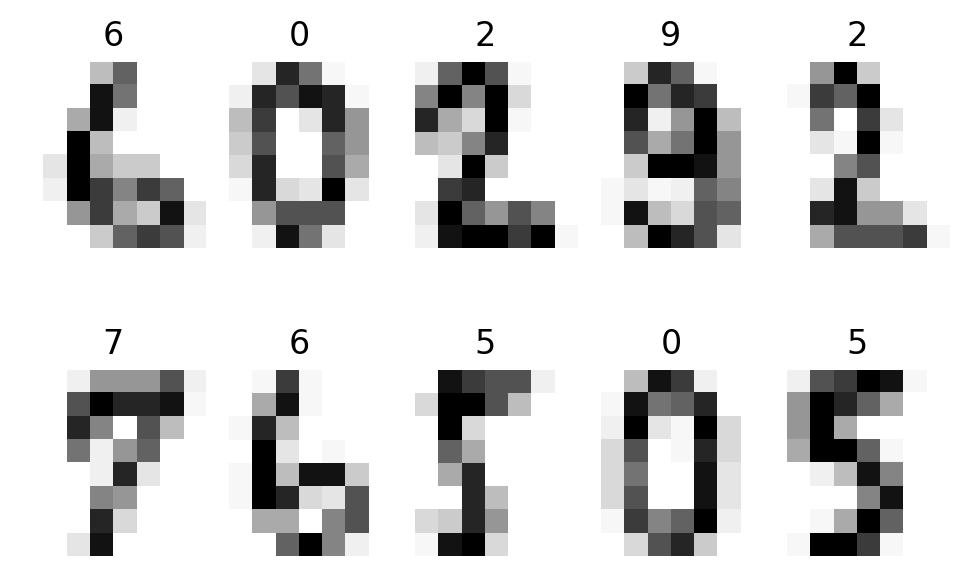

In [12]:
vis.show_dataimage(DS.ss_train.data[10:20], DS.ss_train.label[10:20])

## 6.スパイクトレインの生データを表示

In [13]:
sample = DS.ss_train.spiket[19].view(HP.nt, DA.inputs).T
pd.DataFrame(sample)

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
60,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 7.ラスタープロットを表示

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


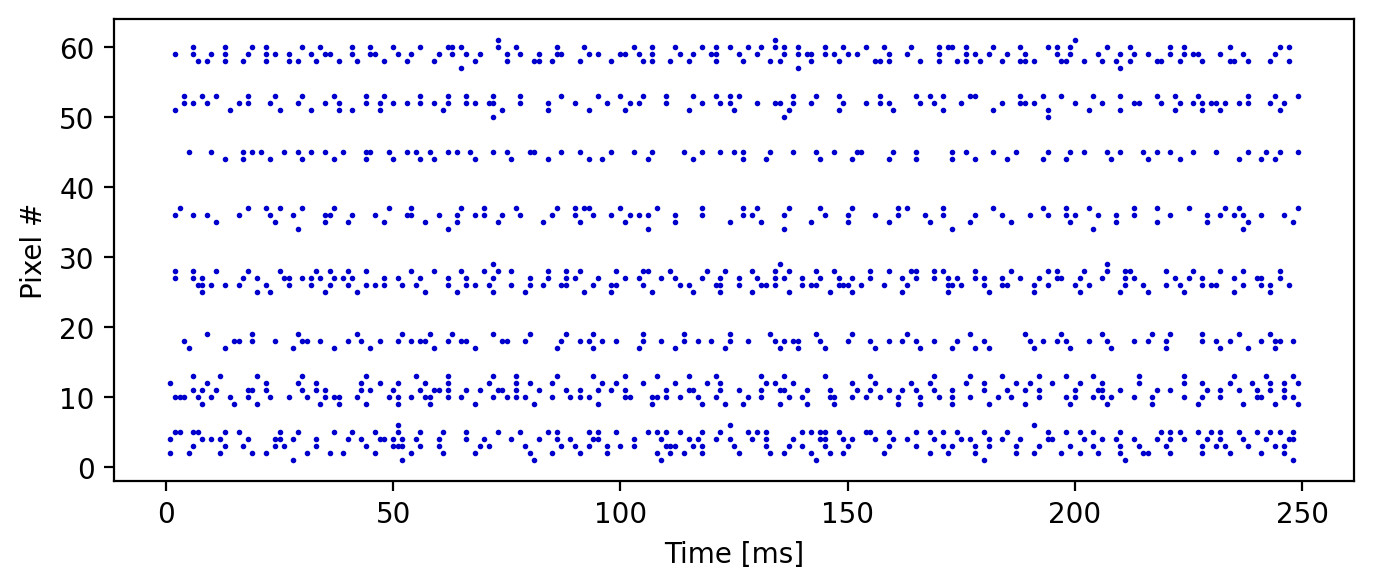

In [14]:
vis.show_rasterplot(sample)

## 8.スパイクトレインを表示

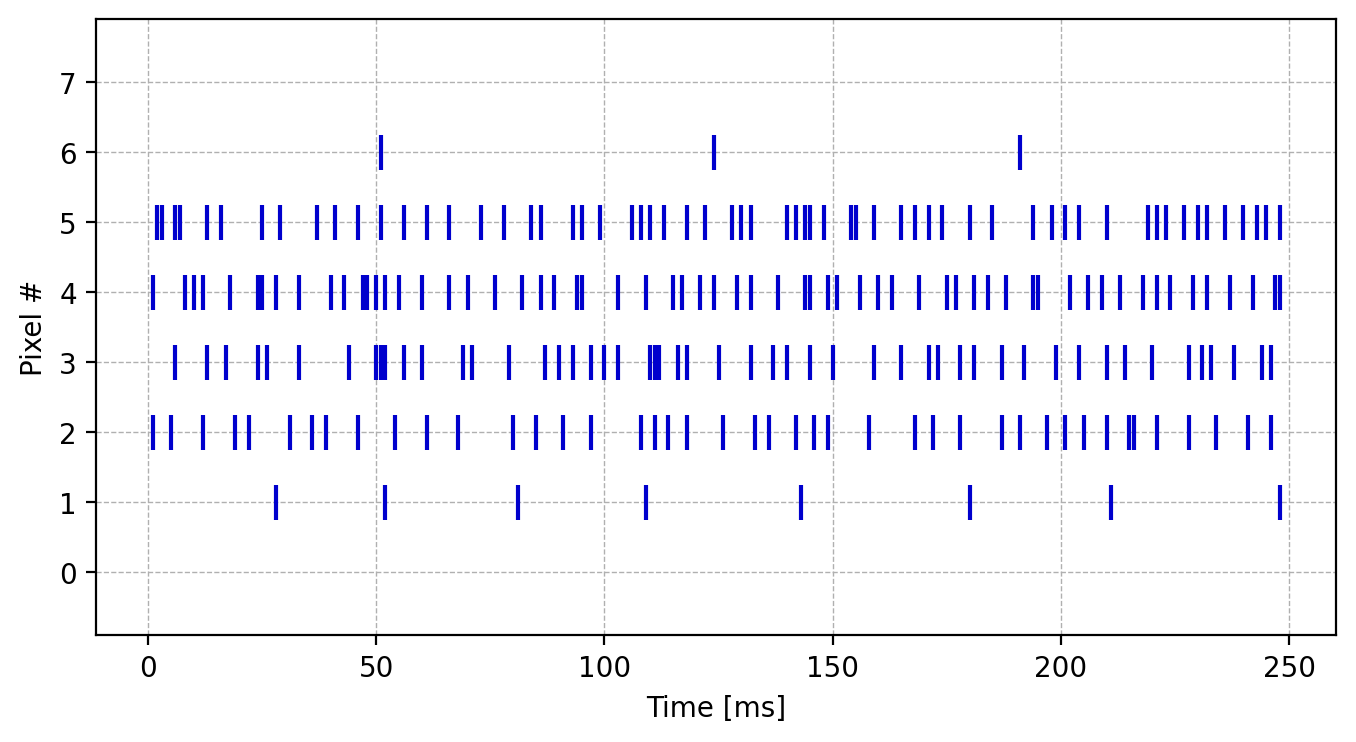

In [15]:
vis.show_spiketrain(sample[0:8])

## 9.モデルを訓練

In [16]:
model = Model(HP, DA)
'''
model.fit(DS.ss_train, HP.epochs, HP.n_trace, assumed_accu) # コードの自己診断を行う
'''
model.fit(DS.ss_train, HP.epochs, HP.n_trace)               # コードの自己診断を行わない


epoch = 1 / 10, update =   5 / 300, accuracy = 0.00%, time = 3.3秒（0分）
epoch = 1 / 10, update =  10 / 300, accuracy = 10.00%, time = 6.5秒（0分）
epoch = 1 / 10, update =  15 / 300, accuracy = 20.00%, time = 11.6秒（0分）
epoch = 1 / 10, update =  20 / 300, accuracy = 20.00%, time = 14.9秒（0分）
epoch = 1 / 10, update =  25 / 300, accuracy = 32.00%, time = 16.6秒（0分）
epoch = 1 / 10, update =  30 / 300, accuracy = 33.33%, time = 18.0秒（0分）
epoch = 1 / 10, update =  35 / 300, accuracy = 42.86%, time = 19.3秒（0分）
epoch = 1 / 10, update =  40 / 300, accuracy = 45.00%, time = 20.8秒（0分）
epoch = 1 / 10, update =  45 / 300, accuracy = 48.89%, time = 22.9秒（0分）
epoch = 1 / 10, update =  50 / 300, accuracy = 50.00%, time = 25.2秒（0分）
epoch = 1 / 10, update =  55 / 300, accuracy = 49.09%, time = 27.3秒（0分）
epoch = 1 / 10, update =  60 / 300, accuracy = 50.00%, time = 28.9秒（0分）
epoch = 1 / 10, update =  65 / 300, accuracy = 50.77%, time = 30.2秒（1分）
epoch = 1 / 10, update =  70 / 300, accuracy = 51.43%, time = 31.5秒

## 10.マップを表示

In [17]:
pd.DataFrame(model.map.view(10,10))

,0,1,2,3,4,5,6,7,8,9
0,1,9,2,7,1,8,7,2,0,0
1,9,6,0,0,0,1,0,0,0,3
2,2,3,4,0,0,7,6,9,3,6
3,4,4,9,8,0,3,5,4,6,3
4,0,5,8,0,4,0,2,0,6,2
5,8,2,6,5,8,8,3,7,0,8
6,0,3,7,6,2,3,3,5,3,9
7,7,9,3,5,3,5,2,9,5,4
8,9,3,2,5,9,7,4,6,5,9
9,1,0,1,7,6,1,3,8,5,0


## 11.ラベルの出現頻度を表示

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


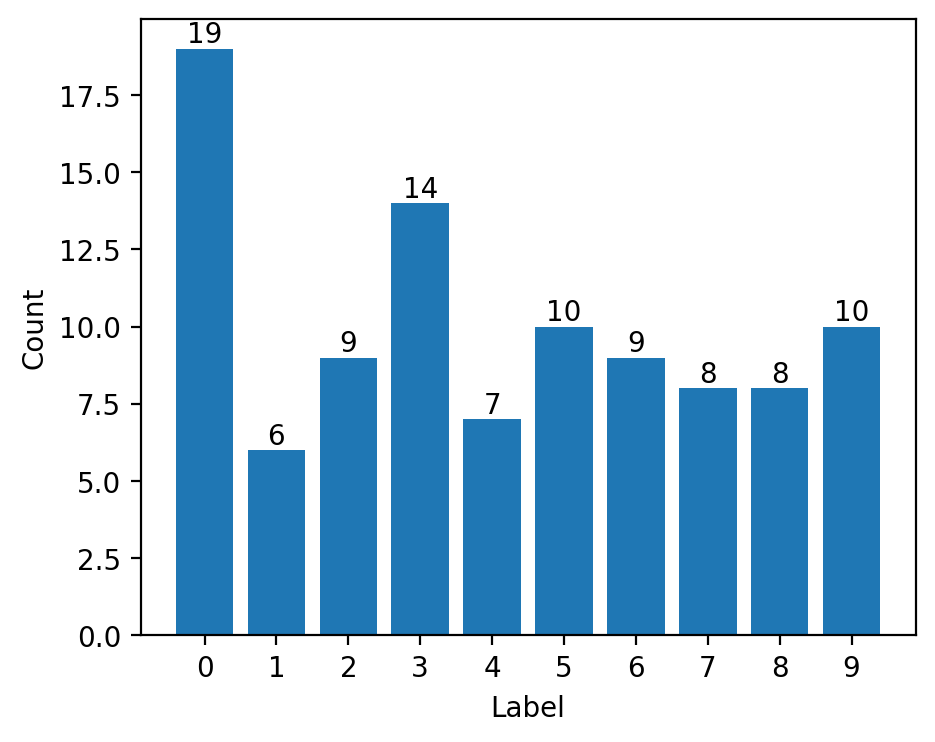

In [18]:
vis.show_labelcount(model.map)

## 12.モデルの性能を評価

In [19]:
set_seed(HP.seed)
model.eval(DS.ss_test)

data =  0, pred = 7, label = 7, judge = ✓ PASS
data =  1, pred = 1, label = 1, judge = ✓ PASS
data =  2, pred = 4, label = 4, judge = ✓ PASS
data =  3, pred = 2, label = 2, judge = ✓ PASS
data =  4, pred = 3, label = 3, judge = ✓ PASS
data =  5, pred = 4, label = 4, judge = ✓ PASS
data =  6, pred = 1, label = 1, judge = ✓ PASS
data =  7, pred = 1, label = 1, judge = ✓ PASS
data =  8, pred = 8, label = 1, judge = ✗ FAIL
data =  9, pred = 6, label = 6, judge = ✓ PASS
data = 10, pred = 9, label = 9, judge = ✓ PASS
data = 11, pred = 0, label = 0, judge = ✓ PASS
data = 12, pred = 1, label = 8, judge = ✗ FAIL
data = 13, pred = 4, label = 4, judge = ✓ PASS
data = 14, pred = 5, label = 5, judge = ✓ PASS
data = 15, pred = 5, label = 5, judge = ✓ PASS
data = 16, pred = 5, label = 8, judge = ✗ FAIL
data = 17, pred = 2, label = 2, judge = ✓ PASS
data = 18, pred = 8, label = 3, judge = ✗ FAIL
data = 19, pred = 7, label = 7, judge = ✓ PASS
data = 20, pred = 5, label = 3, judge = ✗ FAIL
data = 21, pr

## 13.マップの使い方

In [20]:
def show_labelrate(map, rec):                     # ラベルの識別レートを表示
    map = map.numpy()                             # マップ
    rec = rec.numpy()                             # ニューロンの反応（ポイント）
    print('\nラベルの識別レート：')
    for label in range(10):
        point = np.sum(rec[map == label])         # labelの獲得ポイントを集計
        count = np.sum(map == label)              # labelの出現頻度をカウント
        rate  = point / count                     # labelの識別レートを計算
        if rate > 0:
            print(f'label = {label}, point = {point}, '
                  f'count = {count}, rate = {rate:.2f}')


### 【正解例】

In [21]:
#【正解例】　data = 47, pred = 6, label = 6, result = ✓ PASS

model.forward(DS.ss_test.spiket[47], 0)           # 画像#47のスパイクトレインを投入
model.reset_state_variables()
rec = model.spike_record.sum(1)[0]
display(pd.DataFrame(rec.view(10,10)))            # ニューロンの反応を表示
show_labelrate(model.map, rec)                    # ラベルの識別レートを表示

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0



ラベルの識別レート：
label = 6, point = 8.0, count = 9, rate = 0.89


### 【不正解例】

In [22]:
#【不正解例】 data =  8, pred = 8, label = 1, result = ✗ FAIL

model.forward(DS.ss_test.spiket[8], 0)            # 画像#8のスパイクトレインを投入
model.reset_state_variables()
rec = model.spike_record.sum(1)[0]
display(pd.DataFrame(rec.view(10,10)))            # ニューロンの反応を表示
show_labelrate(model.map, rec)                    # ラベルの識別レートを表示

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0



ラベルの識別レート：
label = 2, point = 5.0, count = 9, rate = 0.56
label = 8, point = 9.0, count = 8, rate = 1.12
